In [1]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, col, isnan, to_date, floor, datediff, current_date, round
import matplotlib.pyplot as plt
from pyspark.sql.types import FloatType

In [2]:
spark = SparkSession.builder.appName("case-petlove").getOrCreate()
spark

In [3]:
df = spark.read.csv("data/data-test-analytics.csv", header=True, inferSchema = True)

In [4]:
df.show(5)

+--------------------+-----------------+-----------------+----------+--------------------+--------------------+--------------------+-----------------+------+-------+-----------------+-----+--------------------+------------------+----------------+--------------+----------------+----------+-------+----------------+
|                  id|       created_at|       updated_at|deleted_at|           name_hash|          email_hash|        address_hash|       birth_date|status|version|             city|state|        neighborhood|last_date_purchase|  average_ticket|items_quantity|     all_revenue|all_orders|recency|marketing_source|
+--------------------+-----------------+-----------------+----------+--------------------+--------------------+--------------------+-----------------+------+-------+-----------------+-----+--------------------+------------------+----------------+--------------+----------------+----------+-------+----------------+
|8bf7960e-3b93-468...|08/15/17 07:05 AM|01/14/21 11:23 

In [5]:
df.select(
    [count
        (when
            (col(c).contains('None') | \
            col(c).contains('Null') | \
            (col(c) == '') | \
            col(c).isNull() | \
            isnan(c), c)
        ).alias(c)
    for c in df.columns]).show()

+---+----------+----------+----------+---------+----------+------------+----------+------+-------+----+-----+------------+------------------+--------------+--------------+-----------+----------+-------+----------------+
| id|created_at|updated_at|deleted_at|name_hash|email_hash|address_hash|birth_date|status|version|city|state|neighborhood|last_date_purchase|average_ticket|items_quantity|all_revenue|all_orders|recency|marketing_source|
+---+----------+----------+----------+---------+----------+------------+----------+------+-------+----+-----+------------+------------------+--------------+--------------+-----------+----------+-------+----------------+
|  0|         0|         0|      9495|        0|         0|           0|         0|     0|      0|   0|    0|           0|                 0|             0|             0|          0|         0|      0|               0|
+---+----------+----------+----------+---------+----------+------------+----------+------+-------+----+-----+-----------

In [6]:
df = df.drop('name_hash', 'email_hash', 'address_hash')

In [7]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- updated_at: string (nullable = true)
 |-- deleted_at: string (nullable = true)
 |-- birth_date: string (nullable = true)
 |-- status: string (nullable = true)
 |-- version: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- last_date_purchase: string (nullable = true)
 |-- average_ticket: double (nullable = true)
 |-- items_quantity: integer (nullable = true)
 |-- all_revenue: double (nullable = true)
 |-- all_orders: integer (nullable = true)
 |-- recency: integer (nullable = true)
 |-- marketing_source: string (nullable = true)



In [8]:
df.describe().show()

+-------+--------------------+-----------------+-----------------+-----------------+-----------------+------+-------+--------------------+-----+------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+
|summary|                  id|       created_at|       updated_at|       deleted_at|       birth_date|status|version|                city|state|neighborhood|last_date_purchase|    average_ticket|    items_quantity|      all_revenue|       all_orders|          recency| marketing_source|
+-------+--------------------+-----------------+-----------------+-----------------+-----------------+------+-------+--------------------+-----+------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+
|  count|               10000|            10000|            10000|              505|            10000| 10000|  10000|               10000|1

In [9]:
df = df.withColumn('created_at', to_date(df['created_at'], 'MM/dd/yy hh:mm a')) \
       .withColumn('updated_at', to_date(df['updated_at'], 'MM/dd/yy hh:mm a')) \
       .withColumn('deleted_at', to_date(df['deleted_at'], 'MM/dd/yy hh:mm a')) \
       .withColumn('birth_date', to_date(df['birth_date'], 'MM/dd/yy hh:mm a')-36525) \
       .withColumn('last_date_purchase', to_date(df['last_date_purchase'], 'MM/dd/yy hh:mm a')) 

In [10]:
df.show(1)

+--------------------+----------+----------+----------+----------+------+-------+-----------------+-----+------------------+------------------+----------------+--------------+----------------+----------+-------+----------------+
|                  id|created_at|updated_at|deleted_at|birth_date|status|version|             city|state|      neighborhood|last_date_purchase|  average_ticket|items_quantity|     all_revenue|all_orders|recency|marketing_source|
+--------------------+----------+----------+----------+----------+------+-------+-----------------+-----+------------------+------------------+----------------+--------------+----------------+----------+-------+----------------+
|8bf7960e-3b93-468...|2017-08-15|2021-01-14|      null|1974-07-10|active| 2.31.7| Peixoto da Praia|   AM|Aparecida 7ª Seção|        2021-01-14|151.142941888541|            10|906.857651331245|         6|     35|             crm|
+--------------------+----------+----------+----------+----------+------+-------+---

In [11]:
df = df.withColumn('age',floor(datediff(current_date(), to_date(col('birth_date'), 'M/d/yyyy'))/365.24).cast('integer'))

In [12]:
df = df.withColumn('average_ticket', round(df["average_ticket"].cast(FloatType()),2))  \
       .withColumn('all_revenue', round(df["all_revenue"].cast(FloatType()), 2) ) 

In [13]:
df.show(1)

+--------------------+----------+----------+----------+----------+------+-------+-----------------+-----+------------------+------------------+--------------+--------------+-----------+----------+-------+----------------+---+
|                  id|created_at|updated_at|deleted_at|birth_date|status|version|             city|state|      neighborhood|last_date_purchase|average_ticket|items_quantity|all_revenue|all_orders|recency|marketing_source|age|
+--------------------+----------+----------+----------+----------+------+-------+-----------------+-----+------------------+------------------+--------------+--------------+-----------+----------+-------+----------------+---+
|8bf7960e-3b93-468...|2017-08-15|2021-01-14|      null|1974-07-10|active| 2.31.7| Peixoto da Praia|   AM|Aparecida 7ª Seção|        2021-01-14|        151.14|            10|     906.86|         6|     35|             crm| 48|
+--------------------+----------+----------+----------+----------+------+-------+---------------

Todos os campos estão como string e não queremos que alguns deles sejam string, como por exemplo:

created_at
updated_at
deleted_at
birth_date
status 
last_date_purchase
average_ticket
items_quantity
all_revenue
all_orders
recency

In [14]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- created_at: date (nullable = true)
 |-- updated_at: date (nullable = true)
 |-- deleted_at: date (nullable = true)
 |-- birth_date: date (nullable = true)
 |-- status: string (nullable = true)
 |-- version: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- last_date_purchase: date (nullable = true)
 |-- average_ticket: float (nullable = true)
 |-- items_quantity: integer (nullable = true)
 |-- all_revenue: float (nullable = true)
 |-- all_orders: integer (nullable = true)
 |-- recency: integer (nullable = true)
 |-- marketing_source: string (nullable = true)
 |-- age: integer (nullable = true)



1.  Numérico
	1. Discreta
		1. created_at
		2. updated_at
		3. deleted_at
		4. birth_date
		5. last_date_purchase
		6. items_quantity
		7. recency
		8. age
	2.  Contínua
		1. average_ticket
		2. all_revenue
		3. all_orders
2. Categoricas
	1. ID
	2. status: 3 valores distintos
	3. version:
	4. city
	5. state
	6. neighborhood
	7. marketing_source




In [15]:
df.describe().show()

+-------+--------------------+------+-------+--------------------+-----+------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+
|summary|                  id|status|version|                city|state|neighborhood|    average_ticket|    items_quantity|       all_revenue|       all_orders|          recency| marketing_source|              age|
+-------+--------------------+------+-------+--------------------+-----+------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+
|  count|               10000| 10000|  10000|               10000|10000|       10000|             10000|             10000|             10000|            10000|            10000|            10000|            10000|
|   mean|                null|  null|   null|                null| null|        null|216.89478496551513|            8.4998|1174.888607919311

In [204]:
dfp = df.toPandas()


In [205]:

dummies = pd.get_dummies(dfp['status'])
dfp = dfp.join(dummies)


In [206]:
dfp

,id,created_at,updated_at,deleted_at,birth_date,status,version,city,state,neighborhood,...,average_ticket,items_quantity,all_revenue,all_orders,recency,marketing_source,age,active,canceled,paused
0,8bf7960e-3b93-468b-856e-6c6c5b56f52b,2017-08-15,2021-01-14,None,1974-07-10,active,2.31.7,Peixoto da Praia,AM,Aparecida 7ª Seção,...,151.139999,10,906.859985,6,35,crm,48,1,0,0
1,a39535b5-4647-4680-b4f6-3aed57c1f1ff,2019-12-31,2021-01-08,None,1940-07-06,paused,3.30.12,Fernandes,RR,Santa Isabel,...,236.990005,4,236.990005,1,41,organic_search,82,0,0,1
2,dc067cd2-c021-42bd-8c0e-beb267280e66,2019-03-07,2021-01-07,None,1963-03-18,active,3.28.9,Lopes,RR,Estrela,...,211.960007,13,2331.510010,11,42,organic_search,60,1,0,0
3,b5e4caeb-3a9b-49ed-aa33-5acd06b162c1,2018-07-21,2021-01-10,None,1980-11-21,active,3.34.3,Campos do Campo,PE,Confisco,...,204.110001,8,1224.680054,6,39,organic_search,42,1,0,0
4,d4ff61fc-f008-4e19-b8ae-bd70cfa3ae27,2018-06-08,2021-01-18,None,1959-07-07,active,3.19.8,das Neves,RJ,Vila Suzana Segunda Seção,...,252.940002,9,2023.530029,8,31,crm,63,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,90c9fd5f-80d2-4f59-9970-6b3e6dac5f57,2017-09-12,2021-01-31,None,1961-09-12,active,4.30.12,Souza,RN,Concórdia,...,215.080002,5,1075.400024,5,18,paid_search,61,1,0,0
9996,0edb7aec-8816-4904-bcd7-cbe141391441,2018-04-20,2021-01-18,None,1969-09-15,active,4.28.13,Silveira,AL,São Francisco,...,254.529999,10,2290.729980,9,31,organic_search,53,1,0,0
9997,30130652-d616-4b40-adbb-189e3351016c,2017-08-14,2021-01-03,None,1960-01-14,active,3.18.11,Martins,SC,Frei Leopoldo,...,208.740005,8,1252.449951,6,46,paid_search,63,1,0,0
9998,37b52952-afdd-425a-9149-4012ea48ac87,2017-01-19,2021-01-09,None,1957-08-06,active,5.51.6,Gomes das Flores,PA,Cdi Jatoba,...,211.169998,9,0.000000,0,40,direct,65,1,0,0


In [16]:
print(f'DF Shape: {df.count()} x {len(df.columns)}')


DF Shape: 10000 x 18


In [208]:
dfp.to_csv("data-clean.csv")

In [21]:
df.toPandas().to_csv("data.csv")

In [128]:


# calculate the total transaction amount for each customer
customer_totals = df.groupBy("status").agg(count("id").alias("id"))

# show the results
customer_totals.show()


+--------+----+
|  status|  id|
+--------+----+
|canceled| 505|
|  active|8524|
|  paused| 971|
+--------+----+



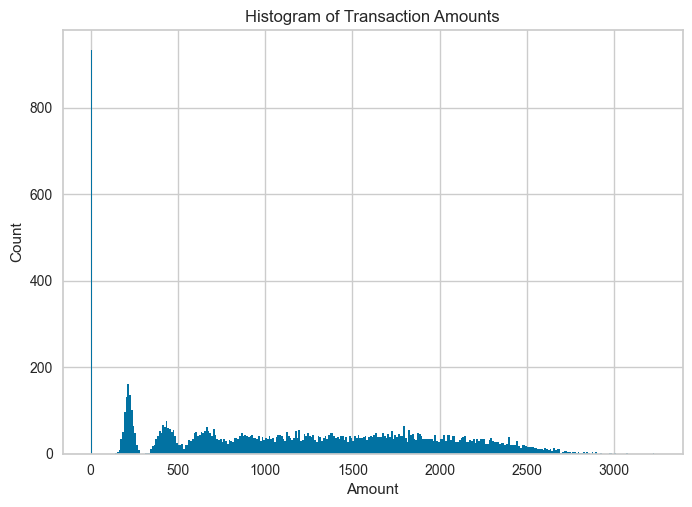

In [129]:
amounts = df.select("all_revenue").rdd.flatMap(lambda x: x).collect()
plt.hist(amounts, bins=np.arange(0, max(amounts)+10, 10))
plt.title("Histogram of Transaction Amounts")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.show()